Notebook dependencies: 
- Visualization: plotly, seaborn, matplotlib
- Data processing: numpy, pandas

TODO 
- [ ] Implement method to give logits for specified tokens (when conditioning on others).

In [158]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import plotting as pdp

# Data processing
import pandas as pd
import numpy as np

t1_text   t1   t2_text     t2  log p_M(t2|t1)    p_M(t2|t1)  \
31727      \n  198     cffff  31727      -21.979847  2.846255e-10   
36977      \n  198   netflix  36977      -21.808453  3.378387e-10   
33209      \n  198      ebus  33209      -20.898594  8.391817e-10   
40516      \n  198         ▒  40516      -20.896549  8.408993e-10   
14950      \n  198  ————————  14950      -20.473671  1.283505e-09   
...       ...  ...       ...    ...             ...           ...   
23         \n  198         8     23       -5.105954  6.060553e-03   
464        \n  198       The    464       -4.412486  1.212500e-02   
24         \n  198         9     24       -5.268563  5.151006e-03   
25214      \n  198       Ask  25214       -7.158193  7.784602e-04   
198        \n  198        \n    198       -1.656806  1.907473e-01   

       log p_D(t2|t1)    p_D(t2|t1)  partition_id  eqw-bins log p_D(t2|t1)  
31727      -15.268683  2.338273e-07             7                        0  
36977      -15.268683  2.338273e-07            18                        0  
33209      -15.268683  2.338273e-07            38                        0  
40516      -15.268683  2.338273e-07             2                        0  
14950      -15.268683  2.338273e-07            24                        0  
...               ...           ...           ...                      ...  
23          -4.231425  1.453166e-02             9                        2  
464         -4.200858  1.498272e-02            29                        2  
24          -3.981154  1.866409e-02             7                        2  
25214       -3.950192  1.925100e-02            25                        2  
198         -1.753758  1.731222e-01             1                        2  

[7193 rows x 10 columns]

In [176]:
def plot_scatter_reg(df, data_probs_str, model_probs_str, title, ax, **kwargs):
    # Consider only the points whose distribution is predetermined
    df = df[~df[data_prob_str].isna()].copy()

    data_probs = df[data_probs_str]
    model_probs = df[model_probs_str]
    
    
    x, y = data_probs, model_probs

    # Scatterplot
    ax.plot(data_probs, model_probs, ".")
    ax.set_xlabel(data_probs_str)
    ax.set_ylabel(model_probs_str)
    
    # Identity line
    ax.plot(x, x, alpha=0.8, linestyle="dashed", color="black", label="y = x")
    
    # Reg plot
    lowess = sm.nonparametric.lowess
    ax.plot(np.sort(x), lowess(y, x)[:, 1], label="LOWESS fit")
    
    ax.set_title(title)
    return ax


def plot_scatterplot_by_partition(df, partition_str, data_probs_str, model_probs_str, title, ax, **kwargs):    
    x_str, y_str = data_probs_str, model_probs_str
    assert "log" not in x_str and "log" not in y_str, "Make sure, you're using probabilities"
    
    # Sum the probability per partition
    part_results = df[[x_str, y_str, partition_str]].groupby(partition_str).sum()
    # Make partition_str column available 
    part_results = part_results.reset_index()
    
    # Do not plot model probabilities not seen in the data
    part_results = part_results[part_results[partition_str] != -1]
    
    sns.scatterplot(part_results, x=x_str, y=y_str, alpha=0.5, hue=partition_str, ax=ax)
    ax.set_title(title)
    return ax


def plot_remaining_prob(df, partition_str, data_probs_str, model_probs_str, ax, **kwargs):
    x_str, y_str = data_probs_str, model_probs_str
    assert "log" not in x_str and "log" not in y_str, "Make sure, you're using probabilities"
    
    # Sum the probability per partition
    df = df.copy() 
    
    # Perhaps partition is not the best way to observe the remaining probability
    # since there can be several t2 that were never seen after t1.
    # instead we may sum the probability for all nan in the data
    df_model_only = df[df[x_str].isna()]

    sns.barplot(x=[df_model_only[x_str].sum()], y=[df_model_only[y_str].sum()], ax=ax)
    ax.set_xlabel(x_str)
    ax.set_ylabel(y_str)
    return df_model_only



def plot_boxplot(df, bins_str, data_probs_str, model_probs_str, ax, **kwargs):
    
    df = pd.concat((
        # Vertically stack probabilities (1) model prob
        pd.DataFrame({
        "src": [model_prob_str] * len(df),
        "p(t2|t1)": df[model_prob_str],
        bins_str: df[bins_str],
        }),
        # Vertically stack probabilities (2) data prob
        pd.DataFrame({
        "src": [data_prob_str] * len(df),
        "p(t2|t1)": df[data_prob_str],
        bins_str: df[bins_str],
        }),
    ))

    plt.figure(figsize=(15, 8))
    sns.boxplot(df, x=bins_str, y="p(t2|t1)", hue="src", ax=ax)
    
    
def create_corrs_table(corrs):
    return corrs.set_index("method").T.to_latex()



In [39]:
def compute_correlation(df, data_probs_str, model_probs_str, **kwargs):
    assert "log" not in data_probs_str
    assert "log" not in model_probs_str
    assert not df[model_probs_str].isna().any()
    from scipy.stats import pearsonr, spearmanr, kendalltau
    
    df = df.copy() 
    
    # Perhaps partition is not the best way to observe the remaining probability
    # since there can be several t2 that were never seen after t1.
    # instead we may sum the probability for all nan in the data
    df[data_probs_str] = df[data_probs_str].fillna(0)

    x = df[data_probs_str]
    y = df[model_probs_str]
    
    results = {"method": [], "statistic": [], "p-val": []}
    
    for corr_meth in (pearsonr, spearmanr, kendalltau):
        out = corr_meth(x, y)
        results["method"].append(corr_meth.__name__)
        results["statistic"].append(out.statistic)
        results["p-val"].append(out.pvalue)

    return pd.DataFrame(results)

## Load Data counts


Dependencies:

- frequencies.py
- joblib

All counts are stored under `/srv/nvme0/ucinlp/cbelem/PILE-30-bigrams-agg/all-2-counts-corrected.pkl`, and it represents a `PositionalFrequency` object, i.e., a python object that contains two attributes:

- `counts`: structure with the absolute counts of each ngram per position in the documents.
- `total_tokens`: number of total counts enclosed in the structure.


`PositionalFrequencies.counts` is structured as follows:

```python
# {
#     <ngram_1>: {
#        pos_0: <counts_of_occ_at_pos_0>, 
#        ..., 
#        pos_i: <counts_of_occ_at_pos_i>
#     }, 
#     ...
#     <ngram_U>: {
#        pos_0: <counts_of_occ_at_pos_0>, 
#        ..., 
#        pos_j: <counts_of_occ_at_pos_j>
#     } 
# }
```

The position's concern the occurrence of the first component in the ngram. Note that some ngrams may occur in some positions but not in others. For example, in the sentence, "I love food", the correpsonding positional frequency structure would be:
```python
{
  ("I", "love"): {0: 1},
  ("love", "food"): {1: 1},
}
```

In this case, the corresponding pkl file represents the ngrams in terms of the GPT2TokenizerFast (since that's the tokenizer used by the models we're considering in this analysis).

In [3]:
from frequencies import PositionalFrequencies


def get_counts_by_position(filepath: str, position: int):
    """Load the counts from the specified filepath
    and keep those only at position 0."""
    import joblib
    data = joblib.load(filepath)
    
    results = {}
    for token, pos_counts in data.counts.items():
        if pos_counts.get(position):
            results[token] = pos_counts[position]
            
    return results

In [5]:
from time import time

1676583672.3129072

In [6]:
start = time()
COUNTS_FILEPATH = "/srv/nvme0/ucinlp/cbelem/PILE-30-bigrams-agg/all-2-counts-corrected.pkl"
COUNTS_AT_0 = get_counts_by_position(COUNTS_FILEPATH, position=0)
end = time()

print("Duration (min):", (end-start) / 60)

Duration (min): 21.83530423641205


### Model - Conditional probability: p_M(t2 | t1)

In [8]:
# We're not actually sampling, but we will use our method to obtain the logits
from sampling.importance_sampler import ImportanceSampler
from typing import Union, List


# Load the sampler (including model + tokenizer)
MODEL_NAME = "EleutherAI/gpt-neo-125M"
SAMPLER = ImportanceSampler(MODEL_NAME, device="cpu")
MODEL = SAMPLER.model
TOKENIZER = SAMPLER.tokenizer

Importing classes for model EleutherAI/gpt-neo-125M
 -> <class 'transformers.models.gpt2.tokenization_gpt2.GPT2Tokenizer'>
 -> <class 'transformers.models.gpt_neo.modeling_gpt_neo.GPTNeoForCausalLM'>
Vocabulary size: 50257
Pad token id: 50256


In [9]:
def model_prob_t2_given_t1(t1: Union[str, int], sampler=SAMPLER) -> List[float]:
    """Compute the conditional probability of p(.|t1) for all t2
    in vocabulary.
    """
    if isinstance(t1, int):
        t1 = sampler.tokenizer.decode(t1)
        print("(model_prob_t2_given_t1) Token:", t1)
    
    # Since we're first interested in comparing the LM distribution
    # when given the first component of a bigram, we will run any
    # method for a single iteration (max_num_tokens=1, num_sequences=1)
    # and get its logits. We will ignore the results of the sampling.
    results = sampler.estimate_marginals(
        input_str=t1,
        terms=" ",
        num_sequences=1,
        max_num_tokens=1,
        seed=20230206,
        return_logits=True,
    )
    
    # Get first decoding step logits
    logits = results.logits[0]
    # Get sampled sequence logits
    logits = logits[0,:]
    
    return {i: l for i, l in enumerate(logits)}
    

# Return all logits
model_prob_t2_given_t1("He"), model_prob_t2_given_t1(1555)

(model_prob_t2_given_t1) Token: ither


({0: -10.670715,
  1: -7.594379,
  2: -10.733366,
  3: -9.959482,
  4: -11.240049,
  5: -9.386578,
  6: -6.134037,
  7: -9.693462,
  8: -9.4653,
  9: -10.412003,
  10: -10.695034,
  11: -7.1571527,
  12: -6.32267,
  13: -8.489273,
  14: -7.622996,
  15: -11.517441,
  16: -9.679476,
  17: -8.945375,
  18: -9.784351,
  19: -10.849829,
  20: -10.258045,
  21: -11.188681,
  22: -11.324324,
  23: -11.860571,
  24: -11.986101,
  25: -9.181446,
  26: -11.293526,
  27: -10.479914,
  28: -10.597122,
  29: -9.854727,
  30: -9.636749,
  31: -11.892393,
  32: -12.088671,
  33: -10.309719,
  34: -10.381554,
  35: -9.672586,
  36: -10.451721,
  37: -11.917904,
  38: -11.109558,
  39: -9.999193,
  40: -9.462156,
  41: -10.026154,
  42: -9.402731,
  43: -10.819771,
  44: -10.550638,
  45: -11.659418,
  46: -10.458078,
  47: -11.779764,
  48: -12.572529,
  49: -10.41893,
  50: -10.623087,
  51: -9.18351,
  52: -12.712843,
  53: -11.290333,
  54: -10.196594,
  55: -11.319448,
  56: -10.850693,
  57: -11

### Data - Conditional probability: p_D(t2 | t1) 

In [10]:
def data_prob_t2_given_t1(t1: Union[int, str], counts: dict) -> dict:
    """Compute the conditional probability of p_D(.|t1)

    The support of p_D(.|t1), i.e., the tokens for which the probability
    is defined can be found by checking the keys of the output.
    """
    print("(data_prob_t2_given_t1) Token:", t1)

    if isinstance(t1, str):
        t1 = TOKENIZER.encode(t1, add_special_tokens=False)[0]
        print("(data_prob_t2_given_t1) Token encoded:", t1)

    prob = {}
    valid_bigrams = filter(lambda bigram: bigram[0] == t1, counts.keys())
    
    for bigram in valid_bigrams:
        t2 = bigram[1]
        prob[t2] = counts[bigram]
    
    # normalize by the number of times t1 appears
    t1_total_counts = sum(prob.values())
    prob = {t2: np.log(t2_cnts / t1_total_counts) for t2, t2_cnts in prob.items()}

    return prob

data_prob_t2_given_t1("He", COUNTS_AT_0), data_prob_t2_given_t1(198, COUNTS_AT_0)

(data_prob_t2_given_t1) Token: He
(data_prob_t2_given_t1) Token encoded: 1544
(data_prob_t2_given_t1) Token: 198


({318: -3.4155583750626803,
  259: -2.7837922309500565,
  7274: -6.623667788142735,
  287: -10.369242585933216,
  12: -6.398950672381095,
  290: -6.101878859579475,
  385: -7.219359632551968,
  423: -9.858416962167226,
  13254: -6.48424825289299,
  403: -7.912506813111913,
  7: -10.369242585933216,
  389: -11.467854874601327,
  694: -4.790771413354191,
  354: -7.037038075758013,
  11: -7.073405719928888,
  1362: -8.523415895434887,
  59: -10.774707694041382,
  12125: -6.205164685696441,
  312: -5.974793431260778,
  19233: -10.774707694041382,
  198: -6.882887395930755,
  776: -3.9673253892060316,
  357: -7.661192384831007,
  5889: -4.067845357438634,
  335: -4.881683219746652,
  449: -7.460521689368856,
  7749: -7.124049452747643,
  289: -10.774707694041382,
  319: -10.774707694041382,
  13: -10.081560513481437,
  468: -3.9930826922034566,
  78: -6.519094984223159,
  1304: -7.830268714874941,
  1040: -7.373510312379226,
  11256: -11.467854874601327,
  9011: -11.467854874601327,
  547: 

### Get partition

Since we're interested in the probability of t2 given t1 $p(t2|t1)$, we will partition the vocabulary size $V$ in two disjoint sets: (1) the terms $V_2$ that appear in the data, (2) the terms $V \setminus V_2$ that do not appear in the data.

1. $V_2$ will be separated into 50 partitions.
2. $V \setminus V_2$ will be separated into equivalent-sized partitions.


In [11]:
VOCAB_SIZE = TOKENIZER.vocab_size
NUM_PARTITIONS = 50 # should change to proportion


def get_t2_counts(bigram_counts: dict) -> dict:
    results = {}
    
    for bigram, counts in bigram_counts.items():
        t2 = bigram[1]
        results.setdefault(t2, 0) #set default value to 0 if it not exists
        results[t2] += counts
        
    return results


def get_partition(data_counts: dict, vocab_size: int, num_partitions: float):
    assert 0 < num_partitions < vocab_size
    

    # Get counts (and sort them by counts descending)
    t2_counts = get_t2_counts(data_counts)
    t2_counts_sorted = sorted(t2_counts.items(), key=lambda b: b[1], reverse=True)

    # Get words that are not represented in the second position of the documents
    # Note: V2 = t2_counts.keys()
    V_except_V2 = [i for i in range(vocab_size) if t2_counts.get(i, None) is None]

    # Partition_ids will be from 0 to 99
    partition_ids = np.arange(len(t2_counts)) % num_partitions
    
    V2_partition_assignment = {
        t2: pid for (t2, _), pid in zip(t2_counts_sorted, partition_ids)
    }
    
    # Add partition assignments for elements no in V2 (partition_id < 0)
    for v in V_except_V2:
        V2_partition_assignment[v] = -1

    return V2_partition_assignment


T2_PARTITIONS = get_partition(COUNTS_AT_0, VOCAB_SIZE, NUM_PARTITIONS)
assert len(T2_PARTITIONS) == VOCAB_SIZE

### Putting everything together

In [185]:
def collect_data(counts: dict, partition_ids: dict, t1, bin_width=400, tokenizer=TOKENIZER):
    def create_bins(max_size: int, step: int):
        bins = []
        for i in range(0, max_size, step):
            bin_size = min(step, max_size-i)
            bins.extend([i // step] * bin_size)
        return bins

    results: pd.DataFrame = None
        
    if isinstance(t1, str):
        t1 = tokenizer.encode(t1, add_special_tokens=False)[0]
    
    # Compute model_prob: t2 | t1 = token
    # (We compute the model probs first, because we will have all tokens)
    model_cond_dist = model_prob_t2_given_t1(t1)
    model_cond_dist = pd.DataFrame(model_cond_dist.items(), columns=["t2", "log p_M(t2|t1)"])
    model_cond_dist["p_M(t2|t1)"] = model_cond_dist["log p_M(t2|t1)"].apply(np.exp)
    assert 1 - model_cond_dist["p_M(t2|t1)"].sum() <= 1e-6

    # Compute data_prob: t2 | t1 = token
    data_cond_dist = data_prob_t2_given_t1(t1, counts) 
    data_cond_dist = pd.DataFrame(data_cond_dist.items(), columns=["t2", "log p_D(t2|t1)"])
    data_cond_dist["p_D(t2|t1)"] = data_cond_dist["log p_D(t2|t1)"].apply(np.exp)
    assert 1 - data_cond_dist["p_D(t2|t1)"].sum() <= 1e-6

    # Merge both distributions (will induce NaNs)
    results = model_cond_dist.merge(data_cond_dist, how="left", on="t2")
    
    # Compute data_prob and model_prob by partition
    partitions = pd.DataFrame(partition_ids.items(), columns=["t2", "partition_id"])
    results = results.merge(partitions, how="inner", on="t2")
    assert results[results["partition_id"] == -1]["log p_D(t2|t1)"].isna().all()
    assert results[results["partition_id"] == -1]["p_D(t2|t1)"].isna().all()
    # ^Note: Assert all partition_id == -1 have p_D == NaN
    
    # Add bins according to data_prob
    # create equal sized bins by grouping every bin-width points)
    results = results.sort_values(by=["log p_M(t2|t1)", "log p_D(t2|t1)"])
    results["eqw-bins log p_D(t2|t1)"] = create_bins(len(results), bin_width) 
        
    # Add human readable version of the tokens
    results.insert(0, "t2_text", results["t2"].apply(tokenizer.decode))
    results.insert(0, "t1", [t1] * len(results))
    results.insert(0, "t1_text", results["t1"].apply(tokenizer.decode))
    
    return results


results = collect_data(COUNTS_AT_0, T2_PARTITIONS, 198, bin_width=2500)
results.head()

(model_prob_t2_given_t1) Token: 

(data_prob_t2_given_t1) Token: 198


t1_text   t1   t2_text     t2  log p_M(t2|t1)    p_M(t2|t1)  \
48058      \n  198   condone  48058      -32.055397  1.198169e-14   
41026      \n  198     joice  41026      -28.989376  2.570833e-13   
33415      \n  198    omsday  33415      -28.637878  3.653654e-13   
28122      \n  198     orget  28122      -28.528183  4.077252e-13   
47703      \n  198       ��極  47703      -28.356499  4.840933e-13   

       log p_D(t2|t1)  p_D(t2|t1)  partition_id  eqw-bins log p_D(t2|t1)  
48058             NaN         NaN            18                        0  
41026             NaN         NaN            11                        0  
33415             NaN         NaN            18                        0  
28122             NaN         NaN            34                        0  
47703             NaN         NaN            39                        0

## Analysis

(model_prob_t2_given_t1) Token: 

(data_prob_t2_given_t1) Token: 198
(model_prob_t2_given_t1) Token: Q
(data_prob_t2_given_t1) Token: 48
(model_prob_t2_given_t1) Token: "
(data_prob_t2_given_t1) Token: 1
(model_prob_t2_given_t1) Token: This
(data_prob_t2_given_t1) Token: 1212
(model_prob_t2_given_t1) Token: The
(data_prob_t2_given_t1) Token: 464
(model_prob_t2_given_t1) Token: In
(data_prob_t2_given_t1) Token: 818
(model_prob_t2_given_t1) Token: I
(data_prob_t2_given_t1) Token: 40
(model_prob_t2_given_t1) Token: He
(data_prob_t2_given_t1) Token: 1544
(model_prob_t2_given_t1) Token: She
(data_prob_t2_given_t1) Token: 3347


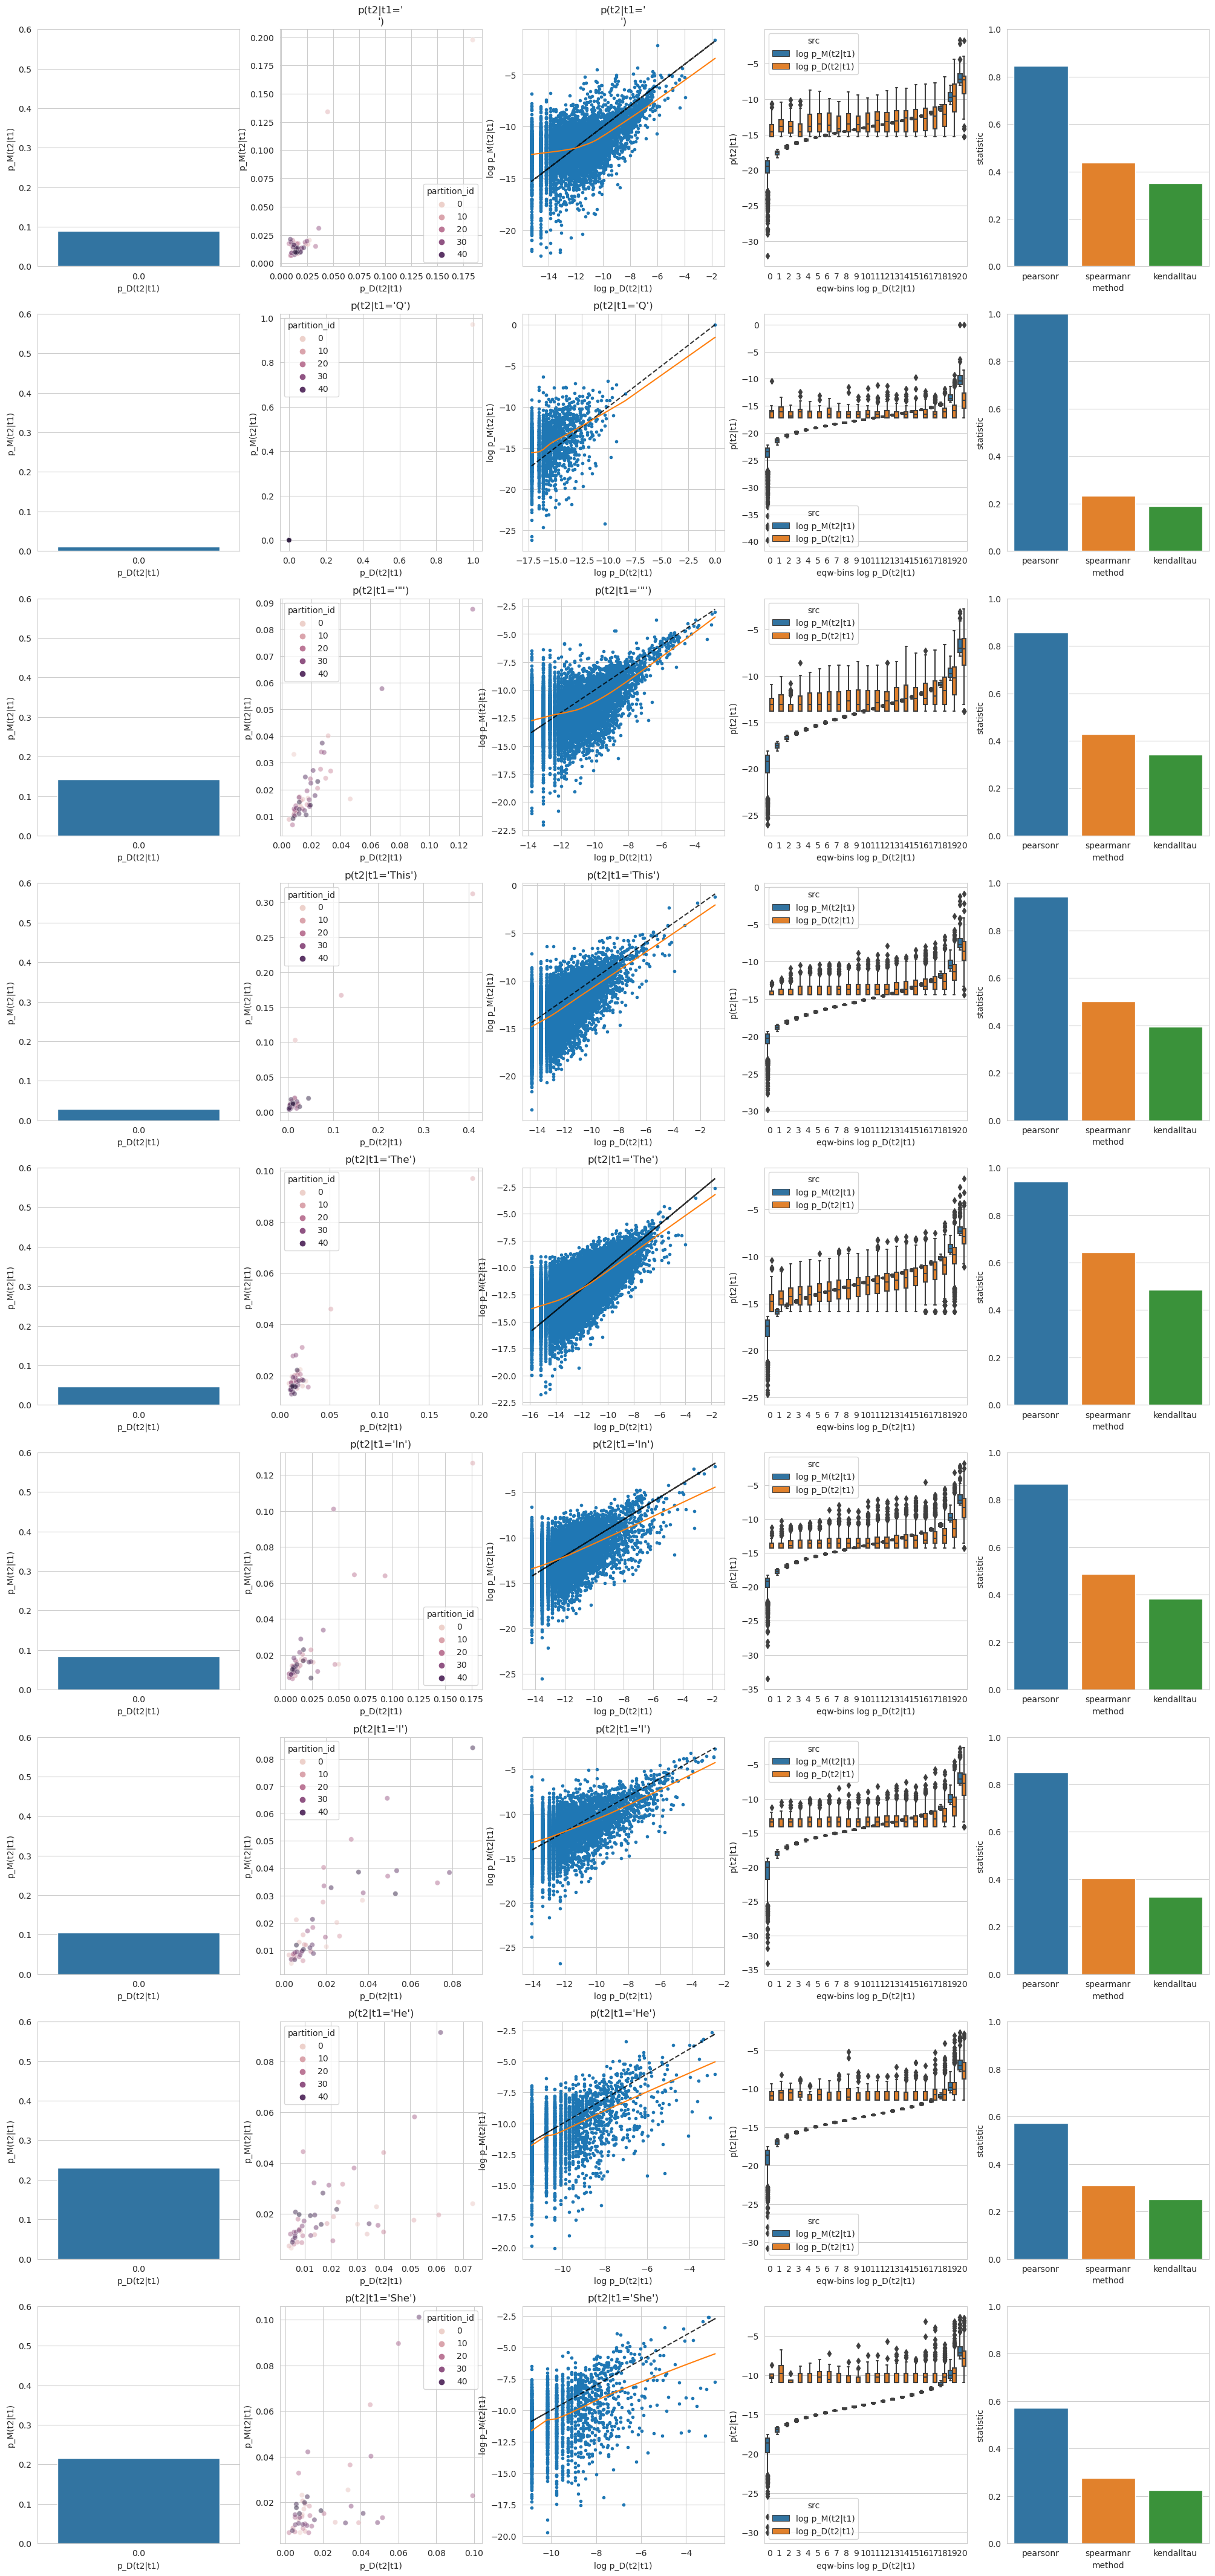

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

In [186]:
t1_tokens = ["\n", "Q", '"', "This", "The", "In", "I", "He", "She"]
t1_results = {t1: collect_data(COUNTS_AT_0, T2_PARTITIONS, t1, bin_width=2500) for t1 in t1_tokens}
t1_corrs = {t1: compute_correlation(t1_df, data_probs_str="p_D(t2|t1)", model_probs_str="p_M(t2|t1)") for t1, t1_df in t1_results.items()}
# -------------------------------------------------------------
# PLOTS 
# -------------------------------------------------------------
n_rows = len(t1_tokens)
fig, axes = plt.subplots(n_rows, 5, figsize=(25, n_rows*6))

default_kwargs = {
    "data_probs_str": "log p_D(t2|t1)", 
    "model_probs_str": "log p_M(t2|t1)",
}

for i in range(n_rows):
    t1 = t1_tokens[i]
    t1_df = t1_results[t1]
    default_kwargs.update({"title": f"p(t2|t1='{t1}')"})
        
    # 1. Remainin probability
    ax = axes[i, 0]
    plot_remaining_prob(t1_df, data_probs_str="p_D(t2|t1)", model_probs_str="p_M(t2|t1)", partition_str="partition_id", ax=ax)
    ax.set_ylim(0, 0.6)
    
    # 1. Partition plot
    ax = axes[i, 1]
    plot_scatterplot_by_partition(t1_df, ax=ax, data_probs_str="p_D(t2|t1)", model_probs_str="p_M(t2|t1)", partition_str="partition_id", title=default_kwargs["title"])
    
    # 2. Scatter plot
    ax = axes[i, 2]
    plot_scatter_reg(t1_df, ax=ax, **default_kwargs)
    
    # 3. Box plot
    ax = axes[i, 3]
    plot_boxplot(t1_df, bins_str="eqw-bins log p_D(t2|t1)", ax=ax, **default_kwargs)
        
#    t1_table = create_corrs_table(t1_corrs[t1])
#     plt.text(0, 0, t1_table)
    
    ax = axes[i, 4]
    sns.barplot(data=t1_corrs[t1], x="method", y="statistic", ax=ax)
    ax.set_ylim(0, 1)
  

(model_prob_t2_given_t1) Token: 0
(data_prob_t2_given_t1) Token: 15
(model_prob_t2_given_t1) Token:  0
(data_prob_t2_given_t1) Token: 657
(model_prob_t2_given_t1) Token: 1
(data_prob_t2_given_t1) Token: 16
(model_prob_t2_given_t1) Token:  1
(data_prob_t2_given_t1) Token: 352
(model_prob_t2_given_t1) Token: 2
(data_prob_t2_given_t1) Token: 17
(model_prob_t2_given_t1) Token:  2
(data_prob_t2_given_t1) Token: 362
(model_prob_t2_given_t1) Token: 3
(data_prob_t2_given_t1) Token: 18
(model_prob_t2_given_t1) Token:  3
(data_prob_t2_given_t1) Token: 513
(model_prob_t2_given_t1) Token: 4
(data_prob_t2_given_t1) Token: 19
(model_prob_t2_given_t1) Token:  4
(data_prob_t2_given_t1) Token: 604
(model_prob_t2_given_t1) Token: 5
(data_prob_t2_given_t1) Token: 20
(model_prob_t2_given_t1) Token:  5
(data_prob_t2_given_t1) Token: 642
(model_prob_t2_given_t1) Token: 6
(data_prob_t2_given_t1) Token: 21
(model_prob_t2_given_t1) Token:  6
(data_prob_t2_given_t1) Token: 718
(model_prob_t2_given_t1) Token: 7


/tmp/ipykernel_266217/3950556353.py:80: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(15, 8))


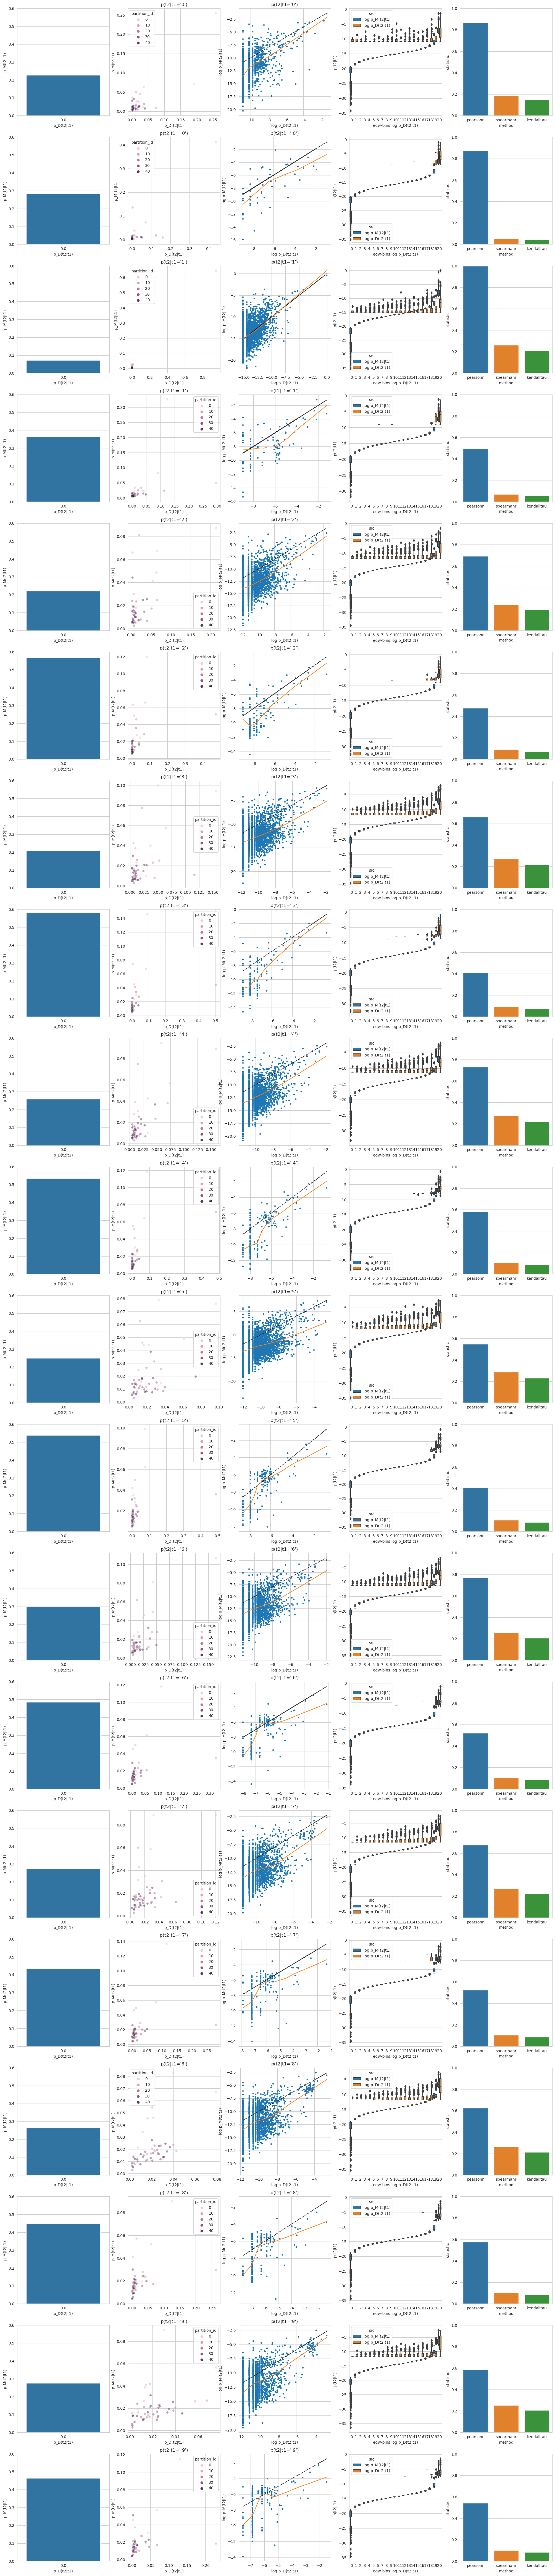

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

In [220]:
t1_tokens = ["0"," 0", "1"," 1", '2', " 2", "3", " 3", "4", " 4", "5", " 5", "6", " 6", "7", " 7", "8"," 8", "9", " 9"]
t1_results = {t1: collect_data(COUNTS_AT_0, T2_PARTITIONS, t1, bin_width=2500) for t1 in t1_tokens}
t1_corrs = {t1: compute_correlation(t1_df, data_probs_str="p_D(t2|t1)", model_probs_str="p_M(t2|t1)") for t1, t1_df in t1_results.items()}
# -------------------------------------------------------------
# PLOTS 
# -------------------------------------------------------------
n_rows = len(t1_tokens)
fig, axes = plt.subplots(n_rows, 5, figsize=(25, n_rows*6))

default_kwargs = {
    "data_probs_str": "log p_D(t2|t1)", 
    "model_probs_str": "log p_M(t2|t1)",
}

for i in range(n_rows):
    t1 = t1_tokens[i]
    t1_df = t1_results[t1]
    default_kwargs.update({"title": f"p(t2|t1='{t1}')"})
        
    # 1. Remainin probability
    ax = axes[i, 0]
    plot_remaining_prob(t1_df, data_probs_str="p_D(t2|t1)", model_probs_str="p_M(t2|t1)", partition_str="partition_id", ax=ax)
    ax.set_ylim(0, 0.6)
    
    # 1. Partition plot
    ax = axes[i, 1]
    plot_scatterplot_by_partition(t1_df, ax=ax, data_probs_str="p_D(t2|t1)", model_probs_str="p_M(t2|t1)", partition_str="partition_id", title=default_kwargs["title"])
    
    # 2. Scatter plot
    ax = axes[i, 2]
    plot_scatter_reg(t1_df, ax=ax, **default_kwargs)
    
    # 3. Box plot
    ax = axes[i, 3]
    plot_boxplot(t1_df, bins_str="eqw-bins log p_D(t2|t1)", ax=ax, **default_kwargs)
        
#    t1_table = create_corrs_table(t1_corrs[t1])
#     plt.text(0, 0, t1_table)
    
    ax = axes[i, 4]
    sns.barplot(data=t1_corrs[t1], x="method", y="statistic", ax=ax)
    ax.set_ylim(0, 1)
  

(model_prob_t2_given_t1) Token: a
(data_prob_t2_given_t1) Token: 64
(model_prob_t2_given_t1) Token: A
(data_prob_t2_given_t1) Token: 32
(model_prob_t2_given_t1) Token:  A
(data_prob_t2_given_t1) Token: 317
(model_prob_t2_given_t1) Token: e
(data_prob_t2_given_t1) Token: 68
(model_prob_t2_given_t1) Token: E
(data_prob_t2_given_t1) Token: 36
(model_prob_t2_given_t1) Token:  E
(data_prob_t2_given_t1) Token: 412
(model_prob_t2_given_t1) Token: i
(data_prob_t2_given_t1) Token: 72
(model_prob_t2_given_t1) Token: I
(data_prob_t2_given_t1) Token: 40
(model_prob_t2_given_t1) Token: b
(data_prob_t2_given_t1) Token: 65
(model_prob_t2_given_t1) Token: B
(data_prob_t2_given_t1) Token: 33
(model_prob_t2_given_t1) Token: o
(data_prob_t2_given_t1) Token: 78
(model_prob_t2_given_t1) Token: O
(data_prob_t2_given_t1) Token: 46
(model_prob_t2_given_t1) Token: u
(data_prob_t2_given_t1) Token: 84
(model_prob_t2_given_t1) Token: U
(data_prob_t2_given_t1) Token: 52
(model_prob_t2_given_t1) Token: z
(data_prob

/home/cbelem/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


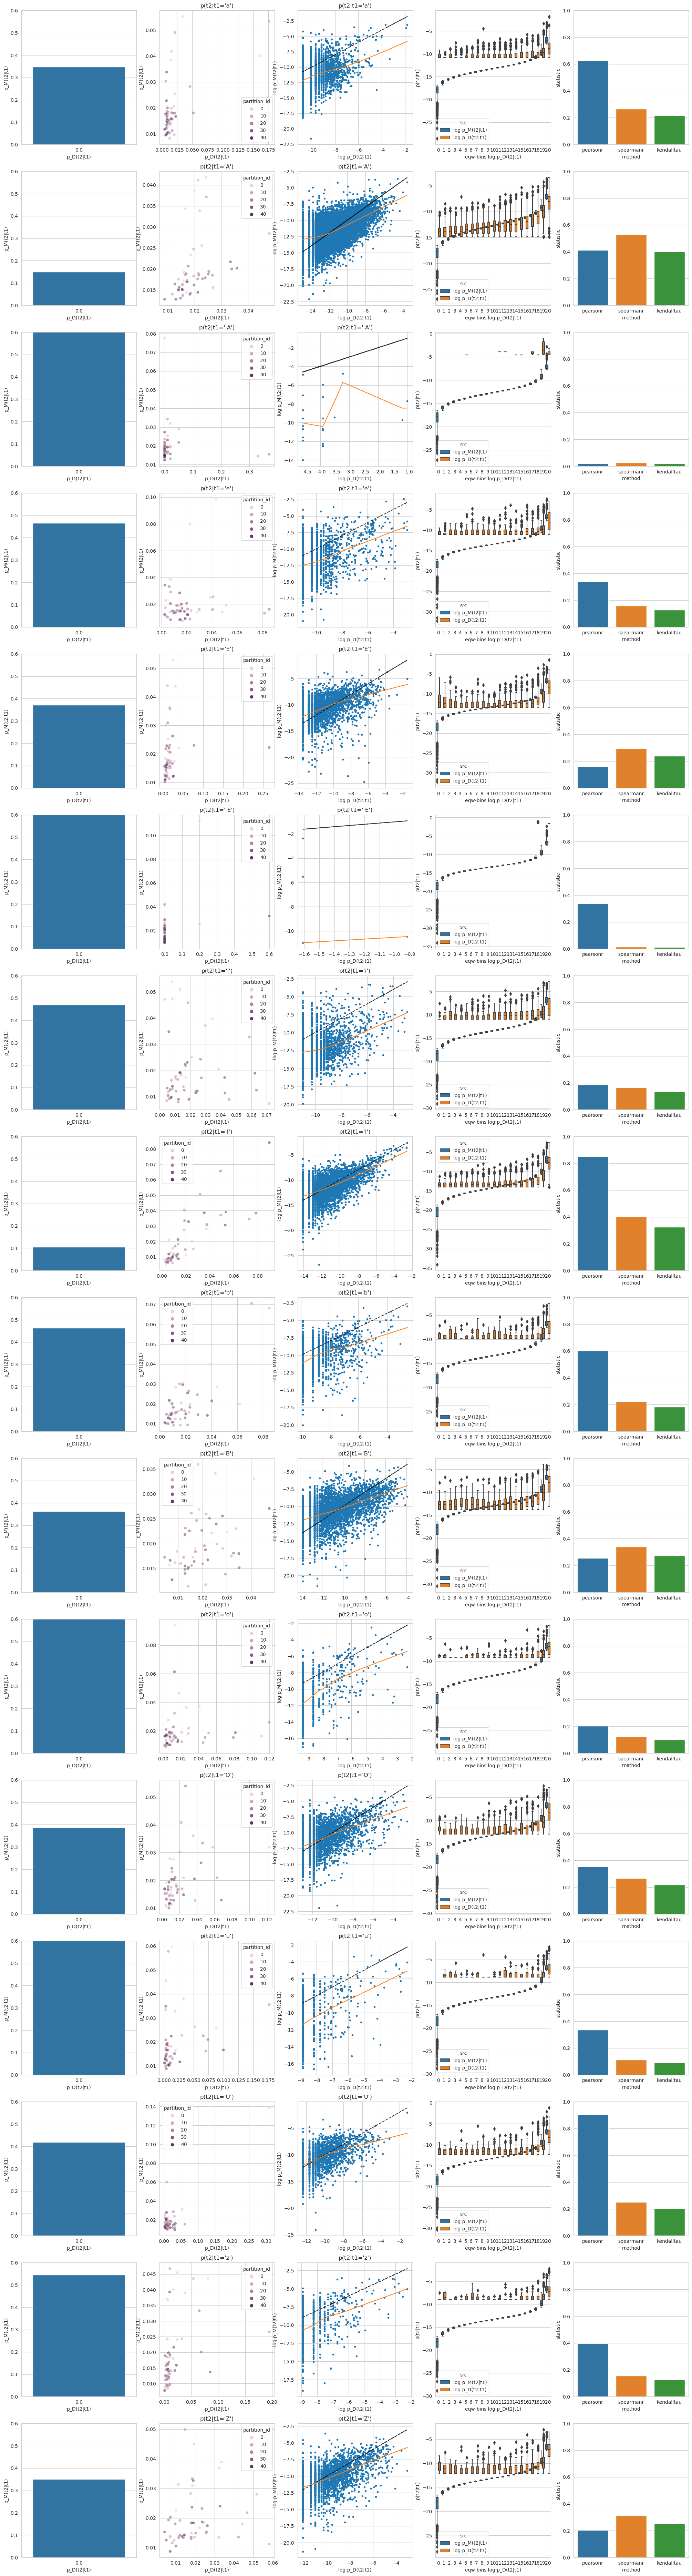

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

In [199]:
t1_tokens = ["a", "A", " A", "e", "E", " E", "i", "I", "b", "B", "o", "O", "u", "U", "z", "Z"]
t1_results = {t1: collect_data(COUNTS_AT_0, T2_PARTITIONS, t1, bin_width=2500) for t1 in t1_tokens}
t1_corrs = {t1: compute_correlation(t1_df, data_probs_str="p_D(t2|t1)", model_probs_str="p_M(t2|t1)") for t1, t1_df in t1_results.items()}
# -------------------------------------------------------------
# PLOTS 
# -------------------------------------------------------------
n_rows = len(t1_tokens)
fig, axes = plt.subplots(n_rows, 5, figsize=(25, n_rows*6))

default_kwargs = {
    "data_probs_str": "log p_D(t2|t1)", 
    "model_probs_str": "log p_M(t2|t1)",
}

for i in range(n_rows):
    t1 = t1_tokens[i]
    t1_df = t1_results[t1]
    default_kwargs.update({"title": f"p(t2|t1='{t1}')"})
        
    # 1. Remainin probability
    ax = axes[i, 0]
    plot_remaining_prob(t1_df, data_probs_str="p_D(t2|t1)", model_probs_str="p_M(t2|t1)", partition_str="partition_id", ax=ax)
    ax.set_ylim(0, 0.6)
    
    # 1. Partition plot
    ax = axes[i, 1]
    plot_scatterplot_by_partition(t1_df, ax=ax, data_probs_str="p_D(t2|t1)", model_probs_str="p_M(t2|t1)", partition_str="partition_id", title=default_kwargs["title"])
    
    # 2. Scatter plot
    ax = axes[i, 2]
    plot_scatter_reg(t1_df, ax=ax, **default_kwargs)
    
    # 3. Box plot
    ax = axes[i, 3]
    plot_boxplot(t1_df, bins_str="eqw-bins log p_D(t2|t1)", ax=ax, **default_kwargs)
        
#    t1_table = create_corrs_table(t1_corrs[t1])
#     plt.text(0, 0, t1_table)
    
    ax = axes[i, 4]
    sns.barplot(data=t1_corrs[t1], x="method", y="statistic", ax=ax)
    ax.set_ylim(0, 1)
  

(model_prob_t2_given_t1) Token: +
(data_prob_t2_given_t1) Token: 10
(model_prob_t2_given_t1) Token: *
(data_prob_t2_given_t1) Token: 9
(model_prob_t2_given_t1) Token: -
(data_prob_t2_given_t1) Token: 12
(model_prob_t2_given_t1) Token: /
(data_prob_t2_given_t1) Token: 14
(model_prob_t2_given_t1) Token: !
(data_prob_t2_given_t1) Token: 0


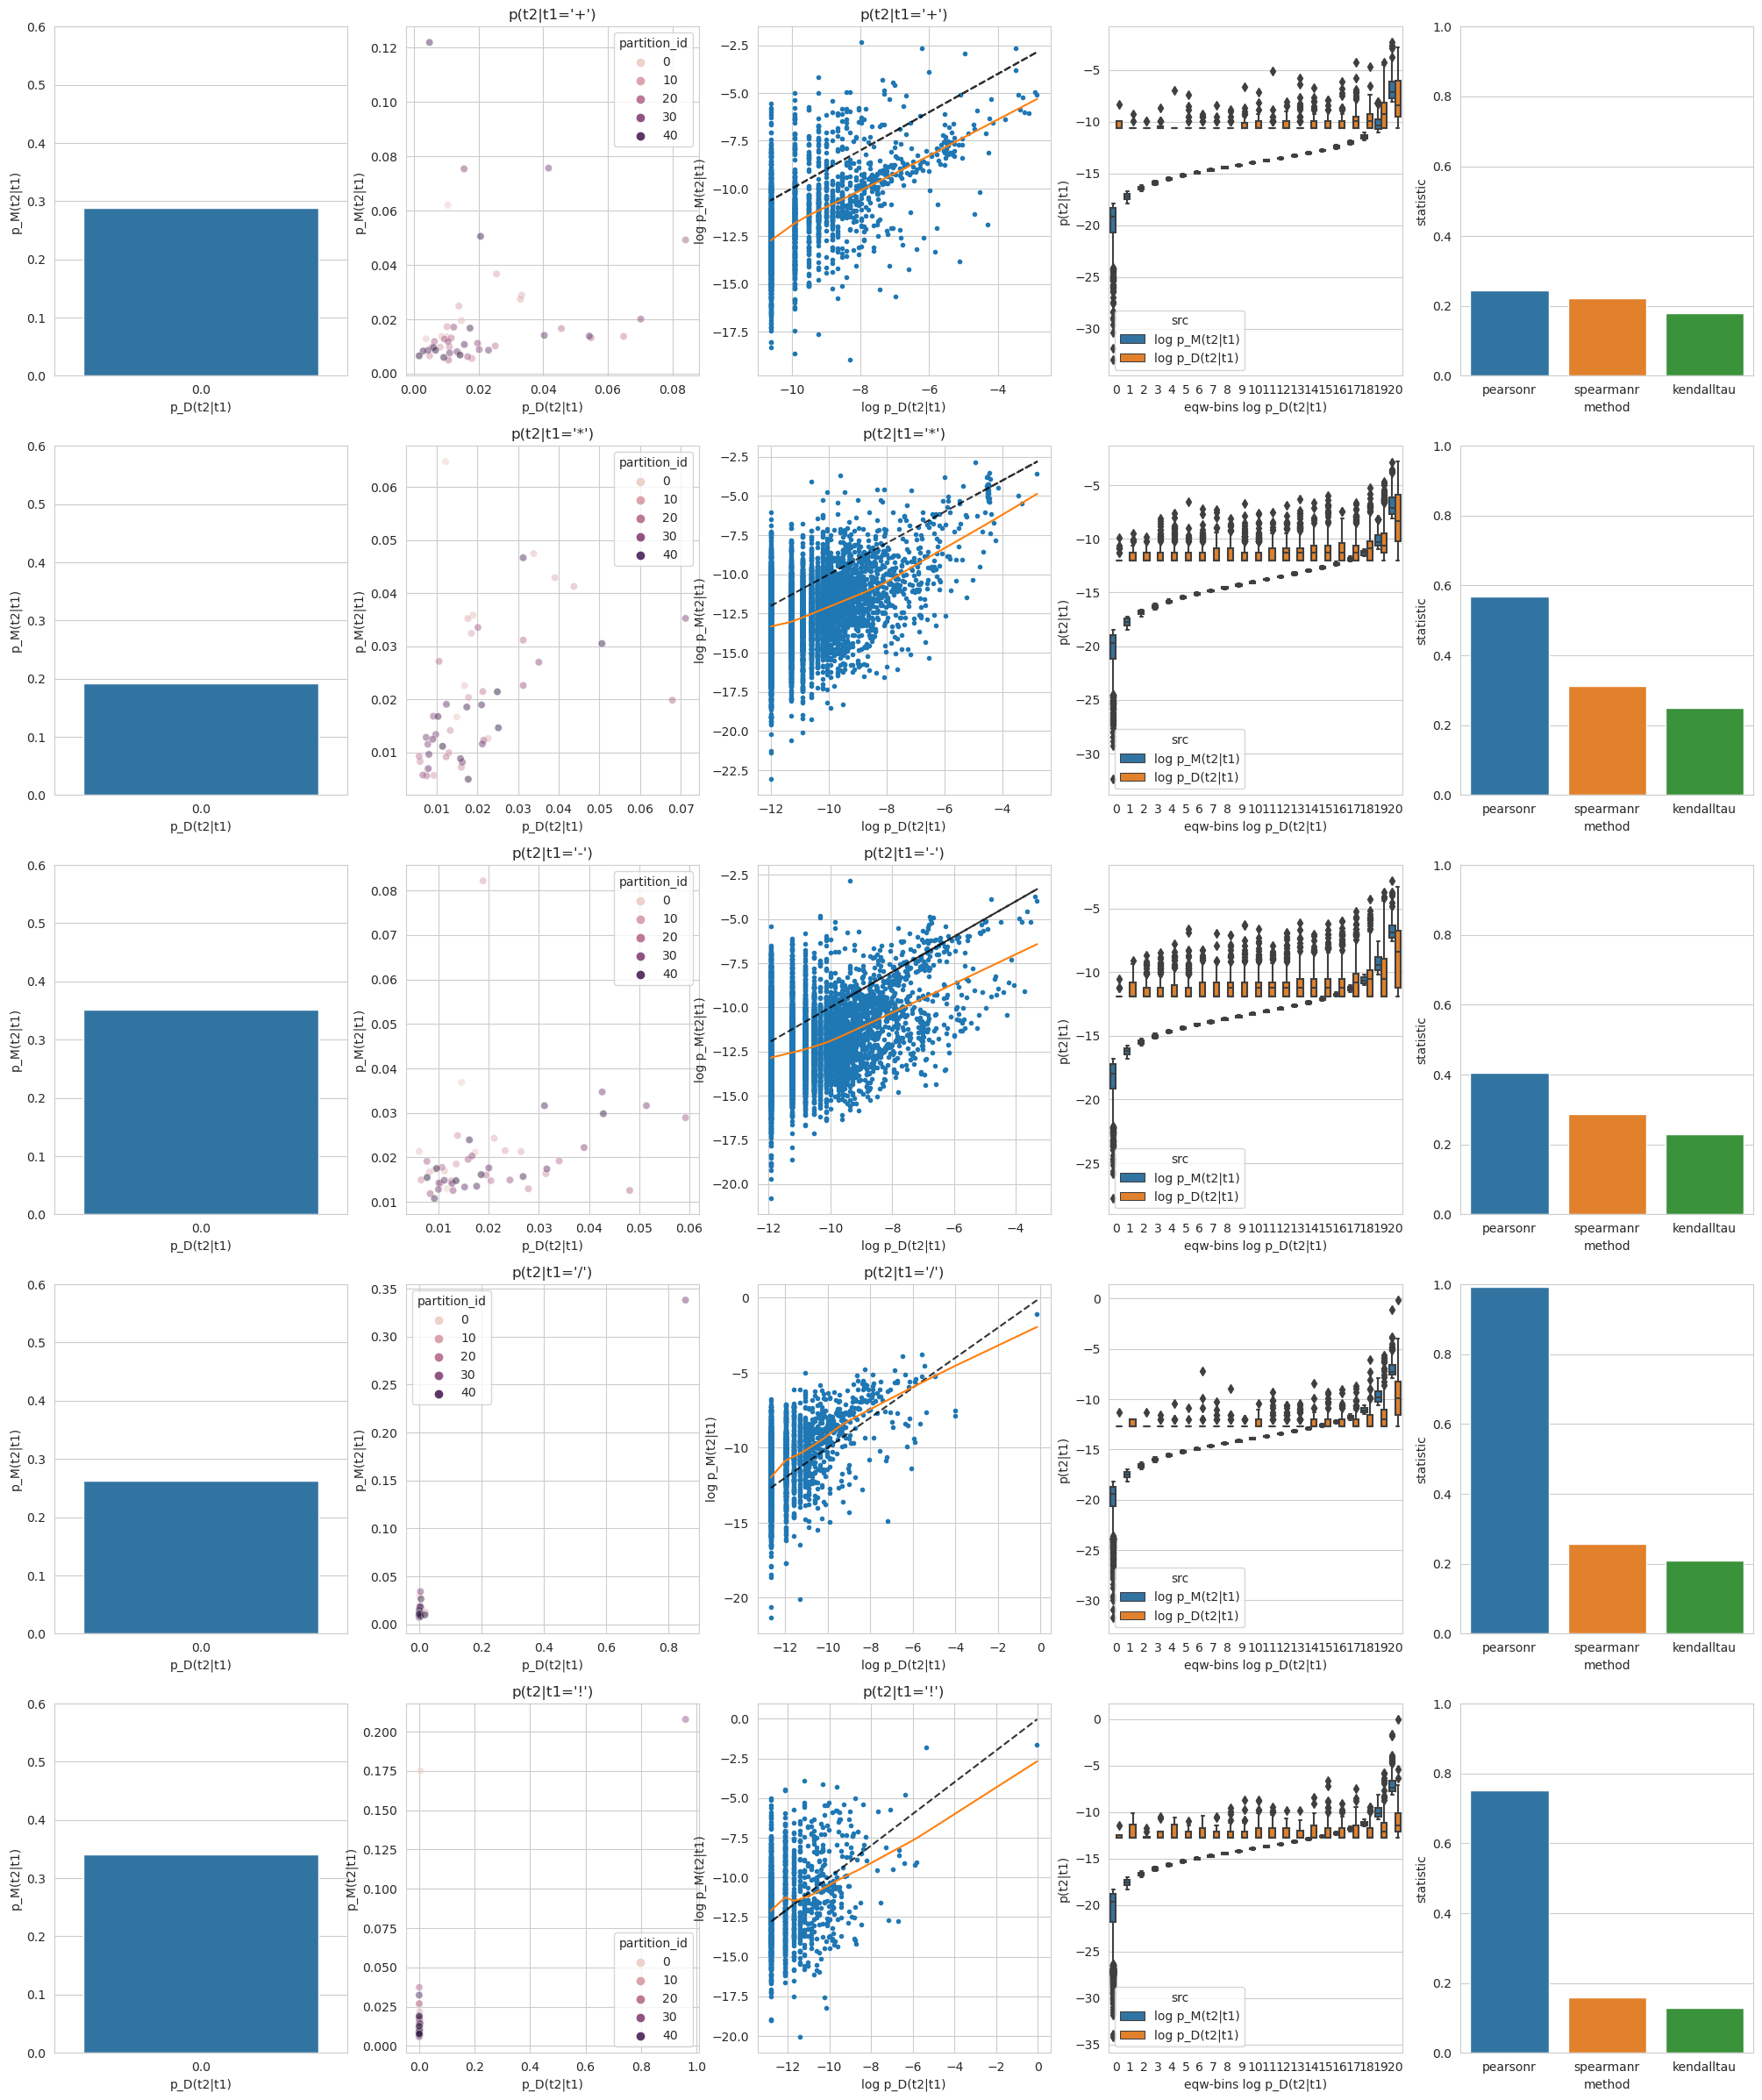

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

In [200]:
t1_tokens = ["+", "*", "-", "/", "!"]
t1_results = {t1: collect_data(COUNTS_AT_0, T2_PARTITIONS, t1, bin_width=2500) for t1 in t1_tokens}
t1_corrs = {t1: compute_correlation(t1_df, data_probs_str="p_D(t2|t1)", model_probs_str="p_M(t2|t1)") for t1, t1_df in t1_results.items()}
# -------------------------------------------------------------
# PLOTS 
# -------------------------------------------------------------
n_rows = len(t1_tokens)
fig, axes = plt.subplots(n_rows, 5, figsize=(25, n_rows*6))

default_kwargs = {
    "data_probs_str": "log p_D(t2|t1)", 
    "model_probs_str": "log p_M(t2|t1)",
}

for i in range(n_rows):
    t1 = t1_tokens[i]
    t1_df = t1_results[t1]
    default_kwargs.update({"title": f"p(t2|t1='{t1}')"})
        
    # 1. Remainin probability
    ax = axes[i, 0]
    plot_remaining_prob(t1_df, data_probs_str="p_D(t2|t1)", model_probs_str="p_M(t2|t1)", partition_str="partition_id", ax=ax)
    ax.set_ylim(0, 0.6)
    
    # 1. Partition plot
    ax = axes[i, 1]
    plot_scatterplot_by_partition(t1_df, ax=ax, data_probs_str="p_D(t2|t1)", model_probs_str="p_M(t2|t1)", partition_str="partition_id", title=default_kwargs["title"])
    
    # 2. Scatter plot
    ax = axes[i, 2]
    plot_scatter_reg(t1_df, ax=ax, **default_kwargs)
    
    # 3. Box plot
    ax = axes[i, 3]
    plot_boxplot(t1_df, bins_str="eqw-bins log p_D(t2|t1)", ax=ax, **default_kwargs)
        
#    t1_table = create_corrs_table(t1_corrs[t1])
#     plt.text(0, 0, t1_table)
    
    ax = axes[i, 4]
    sns.barplot(data=t1_corrs[t1], x="method", y="statistic", ax=ax)
    ax.set_ylim(0, 1)
  

In [ ]:
t1_tokens = ["+", "*", "-", "/", "!"]
t1_results = {t1: collect_data(COUNTS_AT_0, T2_PARTITIONS, t1, bin_width=2500) for t1 in t1_tokens}
t1_corrs = {t1: compute_correlation(t1_df, data_probs_str="p_D(t2|t1)", model_probs_str="p_M(t2|t1)") for t1, t1_df in t1_results.items()}
# -------------------------------------------------------------
# PLOTS 
# -------------------------------------------------------------
n_rows = len(t1_tokens)
fig, axes = plt.subplots(n_rows, 5, figsize=(25, n_rows*6))

default_kwargs = {
    "data_probs_str": "log p_D(t2|t1)", 
    "model_probs_str": "log p_M(t2|t1)",
}

for i in range(n_rows):
    t1 = t1_tokens[i]
    t1_df = t1_results[t1]
    default_kwargs.update({"title": f"p(t2|t1='{t1}')"})
        
    # 1. Remainin probability
    ax = axes[i, 0]
    plot_remaining_prob(t1_df, data_probs_str="p_D(t2|t1)", model_probs_str="p_M(t2|t1)", partition_str="partition_id", ax=ax)
    ax.set_ylim(0, 0.6)
    
    # 1. Partition plot
    ax = axes[i, 1]
    plot_scatterplot_by_partition(t1_df, ax=ax, data_probs_str="p_D(t2|t1)", model_probs_str="p_M(t2|t1)", partition_str="partition_id", title=default_kwargs["title"])
    
    # 2. Scatter plot
    ax = axes[i, 2]
    plot_scatter_reg(t1_df, ax=ax, **default_kwargs)
    
    # 3. Box plot
    ax = axes[i, 3]
    plot_boxplot(t1_df, bins_str="eqw-bins log p_D(t2|t1)", ax=ax, **default_kwargs)
        
#    t1_table = create_corrs_table(t1_corrs[t1])
#     plt.text(0, 0, t1_table)
    
    ax = axes[i, 4]
    sns.barplot(data=t1_corrs[t1], x="method", y="statistic", ax=ax)
    ax.set_ylim(0, 1)
  

### Low frequency tokens


#### Tokens that never appeared in the data (At position 1)

In [194]:
v1 = np.unique([bigram[0] for bigram in COUNTS_AT_0.keys()])

print("Common tokens:")
for v in v1:
    print(v, TOKENIZER.decode(v))

Common tokens:
0 !
1 "
2 #
3 $
4 %
5 &
6 '
7 (
8 )
9 *
10 +
11 ,
12 -
13 .
14 /
15 0
16 1
17 2
18 3
19 4
20 5
21 6
22 7
23 8
24 9
25 :
26 ;
27 <
28 =
29 >
30 ?
31 @
32 A
33 B
34 C
35 D
36 E
37 F
38 G
39 H
40 I
41 J
42 K
43 L
44 M
45 N
46 O
47 P
48 Q
49 R
50 S
51 T
52 U
53 V
54 W
55 X
56 Y
57 Z
58 [
59 \
60 ]
61 ^
62 _
63 `
64 a
65 b
66 c
67 d
68 e
69 f
70 g
71 h
72 i
73 j
74 k
75 l
76 m
77 n
78 o
79 p
80 q
81 r
82 s
83 t
84 u
85 v
86 w
87 x
88 y
89 z
90 {
91 |
92 }
93 ~
126 �
127 �
128 �
129 �
130 �
131 �
132 �
133 �
134 �
135 �
136 �
137 �
138 �
139 �
140 �
141 �
142 �
143 �
144 �
145 �
146 �
147 �
148 �
149 �
150 �
151 �
152 �
153 �
155 �
156 �
157 �
158 �
159 �
160 �
161 �
162 �
163 �
164 �
165 �
166 �
167 �
168 �
169 �
170 �
171 �
172 �
175 �
176 �
188  
189 
190 
191 
193 
195 
196 
197 	
198 

200 
201 
202 
203 
204 
205 
206 
207 
208 
209 
212 
215 
220  
221 
256  t
257  a
258 he
259 in
260 re
261 on
262  the
263 er
264  s
265 at
266  w
267  o
268 en
269  c


In [192]:
print(f"|V1| = {len(v1)} (out of {VOCAB_SIZE})")

|V1| = 15046 (out of 50257)


In [193]:
v2 = [tid for tid, tpid in T2_PARTITIONS.items() if tpid != -1]
print(f"|V1| = {len(v2)} (out of {VOCAB_SIZE})")

# obtain tokens in the vocabulary that never 
# appeared in the second position of a document in PILE
v_except_v2 = [tid for tid, tpid in T2_PARTITIONS.items() if tpid == -1]

print("V except V2")
for v in v_except_v2:
    print(v, TOKENIZER.decode(v))

|V1| = 49720 (out of 50257)
124 �
125 �
152 �
153 �
154 �
173 �
174 �
175 �
177 �
178 �
179 �
180 �
181 �
182 �
183 �
184 �
185 �
186 �
187 �
193 
208 
209 
210 
211 
212 
214 
216 
217 
218 
219 
1977  toget
2941 ccording
3523  citiz
4010  challeng
4183  conflic
4322  confir
4690 ortunately
5392  conclud
5512 },
5571  acknow
5808 ÃÂ
5815 ÃÂÃÂ
6438  裏
6598  behavi
7105  volunte
7134 ��
7601  proport
7782  occas
8351 ":{"
8382  comprom
8755  Awoken
8762 },{"
8980 ¯¯¯¯
9020  arrang
9063 },"
9065  taxp
9286  exha
9364 ÃÂÃÂÃÂÃÂ
9454  incent
9882  neighb
9962 …"
10298 senal
10658 taboola
11039  tremend
11074 ").
11496 .'"
11537 ')
11548  entreprene
11585 eatures
11592  ``(
11689  unnecess
11727  helicop
11737 �
11833  sovere
11885 龍
11919 "},{"
12054  scrut
12179 .),
12292 cedented
12340 "),
12677  tradem
12781 wcsstore
12869  reluct
13018 "},"
13198  earthqu
13562 itialized
13700 」
13979  ();
13984 "?
14004 ,''
14341 PDATE
14531 groupon
14560  disadvant
14827 ÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂ
14

In [217]:
examples = np.random.choice(np.arange(len(v1)), size=100, replace=False)
examples = [TOKENIZER.decode(v1[i]) for i in examples]

for ex in examples:
    ex_df = collect_data(COUNTS_AT_0, T2_PARTITIONS, ex, bin_width=2500)
    
    # Get the higher variance, lowest_frequency words
    break

(model_prob_t2_given_t1) Token: bucks
(data_prob_t2_given_t1) Token: 18999


In [219]:
ex_df.sort_values("log p_D(t2|t1)", ascending=False).head(30)

t1_text     t1    t2_text     t2  log p_M(t2|t1)    p_M(t2|t1)  \
5116    bucks  18999        kin   5116       -9.290161  9.232818e-05   
29617   bucks  18999       orth  29617      -13.780953  1.035161e-06   
7081    bucks  18999        boy   7081      -11.832088  7.267578e-06   
7968    bucks  18999     county   7968      -10.506803  2.734977e-05   
707     bucks  18999         aw    707      -10.247149  3.545847e-05   
552     bucks  18999       comp    552       -9.913257  4.951392e-05   
17      bucks  18999          2     17       -7.292992  6.802898e-04   
25      bucks  18999          :     25       -6.681893  1.253403e-03   
89      bucks  18999          z     89       -5.440432  4.337611e-03   
47703   bucks  18999        ��極  47703      -30.507381  5.633945e-14   
35887   bucks  18999  andestine  35887      -27.501341  1.138464e-12   
32689   bucks  18999     arcity  32689      -27.241982  1.475563e-12   
41225   bucks  18999      Qaida  41225      -27.105579  1.691206e-12   
29085   bucks  18999   orgetown  29085      -26.912920  2.050536e-12   
43897   bucks  18999          �  43897      -26.873592  2.132785e-12   
45640   bucks  18999      uphem  45640      -26.194599  4.205621e-12   
20621   bucks  18999     akespe  20621      -26.146328  4.413611e-12   
4183    bucks  18999    conflic   4183      -26.120514  4.529027e-12   
11737   bucks  18999          �  11737      -26.093012  4.655314e-12   
44112   bucks  18999          黒  44112      -25.954966  5.344433e-12   
20804   bucks  18999          魔  20804      -25.867443  5.833272e-12   
37133   bucks  18999       umsy  37133      -25.831270  6.048140e-12   
42915   bucks  18999       xtap  42915      -25.781937  6.354000e-12   
42983   bucks  18999         ワン  42983      -25.548508  8.024613e-12   
36346   bucks  18999     tackle  36346      -25.501760  8.408648e-12   
39551   bucks  18999  reenshots  39551      -25.263083  1.067536e-11   
30951   bucks  18999     atalie  30951      -25.059029  1.309188e-11   
30956   bucks  18999    impover  30956      -24.962112  1.442422e-11   
41372   bucks  18999     obbies  41372      -24.906063  1.525577e-11   
40591   bucks  18999    noxious  40591      -24.859026  1.599051e-11   

       log p_D(t2|t1)  p_D(t2|t1)  partition_id  eqw-bins log p_D(t2|t1)  
5116        -1.299283    0.272727            41                       19  
29617       -2.397895    0.090909            38                        9  
7081        -2.397895    0.090909             0                       16  
7968        -2.397895    0.090909            21                       18  
707         -2.397895    0.090909            26                       19  
552         -2.397895    0.090909            37                       19  
17          -2.397895    0.090909            32                       20  
25          -2.397895    0.090909             0                       20  
89          -2.397895    0.090909            46                       20  
47703             NaN         NaN            39                        0  
35887             NaN         NaN            15                        0  
32689             NaN         NaN            23                        0  
41225             NaN         NaN             2                        0  
29085             NaN         NaN            14                        0  
43897             NaN         NaN            17                        0  
45640             NaN         NaN            21                        0  
20621             NaN         NaN            22                        0  
4183              NaN         NaN            -1                        0  
11737             NaN         NaN            -1                        0  
44112             NaN         NaN            14                        0  
20804             NaN         NaN            -1                        0  
37133             NaN         NaN            49                        0  
42915             NaN         NaN             1 

In [ ]:
# TODO - 